In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import delay_embedding as embed
import worm_dynamics as worm_dyn
import stats
import clustering_methods as cl

plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
from sklearn.linear_model import LinearRegression

def decay_rate(lifetimes,xrange=[2,500],plot=False,min_counts=10):
    x,y = stats.cumulative_dist(lifetimes,xrange)
    y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    counts = np.array([np.sum(x==x_unique) for x_unique in np.unique(x)])
    sel = counts>min_counts
    logy = np.log(y[sel])
    x = np.sort(np.unique(x))[sel].reshape(-1,1)
    w = counts[sel]
    y = y[sel]

    reg = LinearRegression().fit(x, logy)
    R2 = reg.score(x, logy)

    m = reg.coef_

    b = reg.intercept_
    
    if plot==True:
        plt.title('m = {:.2f}; R2 = {:.5f}'.format(-1/m[0],R2))
        plt.scatter(x,y)
        plt.plot(x,np.exp(m*x+b))
        plt.yscale('log')
        plt.show()
    return np.abs(m[0])

In [3]:
k_B_T = 0.5
f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

f = h5py.File(dir_path+'DoubleWell/tscales_compute_1000_clusters.h5','r')
T_range = np.array(list(f.keys()),dtype='float')
ts_traj_T = []
for T in T_range:
    ts_traj_delay = np.array(f[str(T)]['ts_traj_delay'])
    delay_range = np.array(f[str(T)]['delay_range'])
    length = int(np.array(f[str(T)]['seq_length'])[0])
    ts_traj_T.append(ts_traj_delay)
f.close()

n_clusters=1000
f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_{}.h5'.format(k_B_T,n_clusters),'r')
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_traj = np.array(f['centers_traj'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
f.close()

f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
K_star = np.array(f['K_star'],dtype=int)[0]
f.close()

In [4]:
# participation ratio is probably not a good idea either!!!
    
delay_idx_T = np.zeros(len(T_range),dtype=int)
rate_mix_T = np.zeros((len(T_range),3))
delay_mix_T = np.zeros((len(T_range),3))
for kt,T in enumerate(T_range):
    ts_traj_delay = ts_traj_T[kt]
    mean = np.mean(1/ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(1/ts_traj_delay[:,:,0],0.5,axis=0)
    ciu = np.percentile(1/ts_traj_delay[:,:,0],99.5,axis=0)
    kd = np.argmax(mean)
    print(kd,delay_range[kd]*dt)
    rate_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])
    delay_idx_T[kt] = delay_range[kd]
    mean = np.mean(ts_traj_delay[:,:,0],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)
    delay_mix_T[kt,:] = np.array([mean[kd],cil[kd],ciu[kd]])


345 17.300001
194 9.75
140 7.05
117 5.9
98 4.9500003
81 4.1
72 3.65
69 3.5
66 3.3500001


In [5]:
def obtain_tscales_T(kt,k_B_T,delay,length,plot=False):
    f = h5py.File(dir_path+'DoubleWell/symbol_sequences/labels_phspace_k_B_T_{}_nseeds_1000.h5'.format(k_B_T),'r')
    labels = ma.array(f['labels_traj'],dtype=int)
    centers = np.array(f['centers_traj'])
    f.close()
    
    f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
    sim = np.array(f['simulation'])[int(K_star/2):-int(K_star/2)-1]
    f.close()   
    print(labels.shape,sim.shape)

    
    print(k_B_T,delay)
    lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
    inv_measure = op_calc.stationary_distribution(P)
    final_labels = op_calc.get_connected_labels(labels,lcs)
    n_modes=2
    R = op_calc.get_reversible_transition_matrix(P)
    eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
    eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
    phi2 = eigfunctions[:,1]
    

    c_range,rho_sets,idx,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,R,return_rho=True)
            
    cluster_traj = ma.zeros(labels.shape,dtype=int)
    cluster_traj[sim[:,0]>0] = 1
    
    split_trajs = op_calc.get_split_trajs(cluster_traj,int(length))
    data_decay_rates = []
    data_decay_times = []
    for traj in split_trajs:
        data_lifetimes = stats.state_lifetime(ma.masked_invalid(traj),dt)
        data_decay_rate = decay_rate(np.hstack(data_lifetimes),xrange=[2,500],plot=plot,min_counts=1)
        data_decay_times.append(1/data_decay_rate)
        data_decay_rates.append(data_decay_rate)
        
    return c_range,rho_sets,data_decay_times,data_decay_rates

In [6]:
nseqs = len(op_calc.get_split_trajs(labels_traj,length))
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

In [7]:
tscales_T = np.zeros((len(T_range),nseqs))
decay_rates_T = np.zeros((len(T_range),nseqs))
plt.figure(figsize=(5,5))
crange_T = []
rho_sets_T = []
for kt,k_B_T in enumerate(T_range):
    delay=delay_idx_T[kt]
    print(delay*dt)
    c_range,rho_sets,data_tscales,data_decay_rates = obtain_tscales_T(kt,k_B_T,delay,length)
    tscales_T[kt] = np.array(data_tscales)
    decay_rates_T[kt] = np.array(data_decay_rates)
    crange_T.append(c_range)
    rho_sets_T.append(rho_sets)
    print(np.mean(data_tscales),np.mean(data_decay_rates))

17.30000025779009
(19999993,) (19999993, 2)
0.5 346
20.640159714107313 0.04850871321959366
9.750000145286322
(19999993,) (19999993, 2)
0.75 195
9.990568738862944 0.10015647340013334
7.050000105053186
(19999993,) (19999993, 2)
1.0 141
6.767527985088549 0.1478371865212783
5.900000087916851
(19999993,) (19999993, 2)
1.25 118
5.178023352298604 0.1932523201541761
4.950000073760748
(19999993,) (19999993, 2)
1.5 99
4.290176141388663 0.23316663243607866
4.100000061094761
(19999993,) (19999993, 2)
1.75 82
3.6794026908917563 0.2719586022391492
3.6500000543892384
(19999993,) (19999993, 2)
2.0 73
3.305478430430269 0.3026260458379643
3.500000052154064
(19999993,) (19999993, 2)
2.25 70
3.0017142898757188 0.333267812770734
3.35000004991889
(19999993,) (19999993, 2)
2.5 67
2.765419769928233 0.36169491588261643


<Figure size 360x360 with 0 Axes>

In [8]:
half_tscales_T_ci = np.vstack([np.mean(tscales_T*.5,axis=1),np.percentile(tscales_T*.5,2.5,axis=1),np.percentile(tscales_T*.5,97.5,axis=1)]).T

In [9]:
f = h5py.File(dir_path+'DoubleWell/kinetic_analysis/combined_coarse_tscales_results_1000_clusters.h5','r')
delay_range = np.array(f['delay_range'])
all_timps = np.array(f['timps'])
T_range = np.array(f['T_range'])
f.close()

In [10]:
y_coarse_operator = []
y_data=[]
for kT,k_B_T in enumerate(T_range):
    y_data.append(half_tscales_T_ci[kT])
    mean = all_timps[kT,:,:].mean(axis=0)
    cil = np.percentile(all_timps[kT,:,:],2.5,axis=0)
    ciu = np.percentile(all_timps[kT,:,:],97.5,axis=0)
    y_coarse_operator.append([mean,cil,ciu])

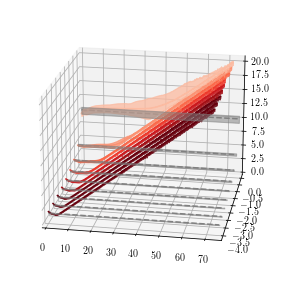

In [11]:
from mpl_toolkits.mplot3d import Axes3D
x = delay_range*dt
zmax=20.5
xmax=75.5
sel_x = x<xmax
offset=.5

plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
angles = [20,-80]
ax.view_init(angles[0],angles[1])

    
for kt in np.arange(len(T_range)):
    y = np.zeros(x.size)-kt*offset
    z_operator = y_coarse_operator[kt]
    z_data = y_data[kt]
    sel_zo = np.logical_and(x<xmax,z_operator[2]<zmax)

    ax.plot(x[sel_zo],y[sel_zo],z_operator[0][sel_zo],c=colors_[kt])
    ax.add_collection3d(plt.fill_between(x[sel_zo],z_operator[1][sel_zo],z_operator[2][sel_zo],alpha=.5,color=colors_[kt]),zs = -kt*offset,zdir='y')
    ax.plot(x[sel_x],y[sel_x],np.ones(len(mean))[sel_x]*z_data[0],c='gray',ls='--')
    ax.add_collection3d(plt.fill_between(x[sel_x],np.ones(len(mean))[sel_x]*z_data[1],np.ones(len(mean))[sel_x]*z_data[2],color='gray',alpha=.3),zs = -kt*offset,zdir='y')
ax.set_zlim3d(0,zmax)
ax.set_xlim3d(0,xmax)
# plt.savefig('coarse_tscales_DW_3d_{}_{}.pdf'.format(angles[0],angles[1]))
plt.show()
    

In [3]:
n_clusters=1000
k_B_T=0.5
dt=.05
f = h5py.File(dir_path+'DoubleWell/kinetic_analysis/combined_kinetic_results_clusters_{}_simpler.h5'.format(n_clusters),'r')
T_range = np.sort(np.array(list(f.keys()),dtype=float))
idx_range = np.sort(np.array(list(f[str(T_range[0])]),dtype=int))
delay_range = np.arange(2,2000,2)
all_timps = np.zeros((len(T_range),len(idx_range),len(delay_range),2))
for kt,k_B_T in enumerate(T_range):
    kidx=0
    for idx in idx_range:
        if len(list(f[str(k_B_T)][str(idx)].keys()))>0:
            if  np.array(f[str(k_B_T)][str(idx)]['timps']).sum()>0:
                all_timps[kt,kidx,:] = np.array(f[str(k_B_T)][str(idx)]['timps'])
                kidx+=1
f.close()

all_timps = ma.masked_invalid(all_timps)
all_timps[all_timps==0] = ma.masked

In [13]:
y_coarse_operator = []
for kT,k_B_T in enumerate(T_range):
    Lambda2 = 1/all_timps[kT,:,:,0]+ 1/all_timps[kT,:,:,1]

    mean = np.nanmean(2/ma.filled(Lambda2,np.nan),axis=0)
    cil = np.nanpercentile(2/ma.filled(Lambda2,np.nan),2.5,axis=0)
    ciu = np.nanpercentile(2/ma.filled(Lambda2,np.nan),97.5,axis=0)

    y_coarse_operator.append([mean,cil,ciu])

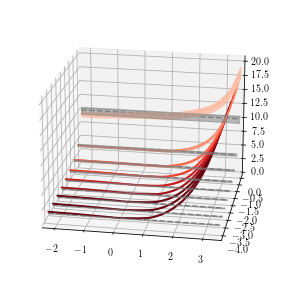

In [14]:
from mpl_toolkits.mplot3d import Axes3D
x = np.log(delay_range*dt)
zmax=20.5
xmax=3.5
sel_x = x<xmax
offset=.5

plt.figure(figsize=(5,5))
ax = plt.subplot(projection='3d')
angles = [20,-80]
ax.view_init(angles[0],angles[1])

    
for kt in np.arange(len(T_range)):
    y = np.zeros(x.size)-kt*offset
    z_operator = y_coarse_operator[kt]
    z_data = y_data[kt]
    sel_zo = np.logical_and(x<xmax,z_operator[2]<zmax)

    ax.plot(x[sel_zo],y[sel_zo],z_operator[0][sel_zo],c=colors_[kt])
    ax.add_collection3d(plt.fill_between(x[sel_zo],z_operator[1][sel_zo],z_operator[2][sel_zo],alpha=.5,color=colors_[kt]),zs = -kt*offset,zdir='y')
    ax.plot(x[sel_x],y[sel_x],np.ones(len(mean))[sel_x]*z_data[0],c='gray',ls='--')
    ax.add_collection3d(plt.fill_between(x[sel_x],np.ones(len(mean))[sel_x]*z_data[1],np.ones(len(mean))[sel_x]*z_data[2],color='gray',alpha=.3),zs = -kt*offset,zdir='y')
ax.set_zlim3d(0,zmax)
ax.set_xlim3d(x.min(),xmax)
# plt.savefig('tscales_coarse_DW_3d_{}_{}.pdf'.format(angles[0],angles[1]))
plt.show()
    